In [1]:
% tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import DenseNet121, DenseNet169

import gc
import cv2
import numpy as np 
import pandas as pd
import random 
import os
from tqdm.auto import tqdm
import pickle
import time
import albumentations
from albumentations.core.transforms_interface import DualTransform, ImageOnlyTransform
from albumentations.augmentations import functional as F

from sklearn.model_selection import train_test_split

TensorFlow 2.x selected.


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Preprocessing

In [0]:
from pathlib import Path
import shutil 
import cv2
import albumentations as A

def findEdge(pic, lim=30):

  for x1 in range(0, 236, 2):
    flag = 0
    for i in range(0, 137, 2):
      if pic[i][x1] < lim:
        flag = 1
        break
    if flag == 1:
      break

  for x2 in range(235, -1, -2):
    flag = 0
    for i in range(0, 137, 2):
      if pic[i][x2] < lim:
        flag = 1
        break
    if flag == 1:
      break
  
  for y1 in range(0, 137, 2):
    flag = 0
    for i in range(0, 236, 2):
      if pic[y1][i] < lim:
        flag = 1
        break
    if flag == 1:
      break
  
  for y2 in range(136, -1, -2):
    flag = 0
    for i in range(0, 236, 2):
      if pic[y2][i] < lim:
        flag = 1
        break
    if flag == 1:
      break

  return min(x1, x2), max(x1, x2), min(y1, y2), max(y2, y1)

def changeshape(pic, H):
            
    return cv2.resize(pic,(H,H))

# all_data = pd.read_parquet("/content/drive/My Drive/Untitled folder/bengaliai-cv19/train_image_data_3.parquet", engine = 'pyarrow')
# pickle.dump(all_data, open("/content/drive/My Drive/Untitled folder/bengaliai-cv19/train_3", 'wb'))
SIZE = 128

for j in range(4):

  all_data = pickle.load(open(f"/content/drive/My Drive/Untitled folder/bengaliai-cv19/train_{j}", 'rb'))

  # tot_file_0 = open("/content/drive/My Drive/Untitled folder/bengaliai-cv19/Resized/train_0_96x96", 'rb')
  # tot_data_0 = pickle.load(tot_file_0)
  # tot_file_1 = open("/content/drive/My Drive/Untitled folder/bengaliai-cv19/Resized/train_1_96x96", 'rb')
  # tot_data_1 = pickle.load(tot_file_1)
  # tot_file_2 = open("/content/drive/My Drive/Untitled folder/bengaliai-cv19/Resized/train_2_96x96", 'rb')
  # tot_data_2 = pickle.load(tot_file_2)
  # tot_file_3 = open("/content/drive/My Drive/Untitled folder/bengaliai-cv19/Resized/train_3_96x96", 'rb')
  # tot_data_3 = pickle.load(tot_file_3)
  # tot_data = pd.concat([pd.DataFrame(tot_data_0), pd.DataFrame(tot_data_1), pd.DataFrame(tot_data_2), pd.DataFrame(tot_data_3)],ignore_index=True)
  all_data.drop(["image_id"], axis = 1, inplace = True)
  # del tot_file_0
  # del tot_file_1
  # del tot_file_2
  # del tot_file_3
  new_data = [0] * all_data.shape[0]

  # base_dir = "/content/drive/My Drive/Untitled folder/bengaliai-cv19/train_new"
  # base_path = Path(base_dir)
  # if base_path.exists():
  #   shutil.rmtree(base_path)
  # base_path.mkdir(parents = True)

  # df = pd.read_csv("/content/drive/My Drive/Untitled folder/bengaliai-cv19/train.csv")
  # df = df[:all_data.shape[0]]
  # # df = df[all_data.shape[0]: 2*all_data.shape[0]]
  # # df = df[2*all_data.shape[0]:3*all_data.shape[0]]
  # # df = df[3*all_data.shape[0]:4*all_data.shape[0]]
  # # df.reset_index(drop=True, inplace=True)

  # df['file_path'] = ""

  # for i in range(168):
  #   for j in range(11):
  #     for k in range(7):
  #       img_dir = base_dir + "/" + str(i) + "/" + str(j) + "/" + str(k) 
  #       img_path = Path(img_dir)
  #       if img_path.exists():
  #         shutil.rmtree(img_path)
      
  #       img_path.mkdir(parents = True)

  for i in tqdm(range(all_data.shape[0])):
      curpic = np.reshape(all_data.loc[i].values, (137, 236))
      # curpic = np.array(curpic,dtype=np.float)
      augBright=A.RandomBrightnessContrast(p=1.0)
      curpic = augBright(image=curpic)['image']
      _, thresh = cv2.threshold(curpic, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
      contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

      idx = 0 
      ls_xmin = []
      ls_ymin = []
      ls_xmax = []
      ls_ymax = []
      for cnt in contours:
          idx += 1
          x,y,w,h = cv2.boundingRect(cnt)
          ls_xmin.append(x - 13 if (x>13) else 0)
          ls_ymin.append(y - 10 if (y>10) else 0)
          ls_xmax.append(x+w+13 if (x+w < 223) else 236)
          ls_ymax.append(y+h+10 if (y+h < 127) else 137)
      xmin = min(ls_xmin)
      ymin = min(ls_ymin)
      xmax = max(ls_xmax)
      ymax = max(ls_ymax)

      curpic = curpic[ymin:ymax,xmin:xmax]
      newpic = changeshape(curpic, SIZE)
      newpic = np.reshape(newpic, (SIZE, SIZE))
      del curpic
  #    img_dir = base_dir + "/" + str(df['grapheme_root'][i]) + "/" + str(df['vowel_diacritic'][i]) + "/" + str(df['consonant_diacritic'][i]) 
      # img_save_dir = base_dir + "/" + df['image_id'][i] + ".png"
      # class_folder_path = Path(class_folder)
      # class_folder_path.mkdir(parents = True)
      new_data[i] = np.reshape(newpic, (SIZE*SIZE))
      # cv2.imwrite(img_save_dir, newpic)
      # df['file_path'][i] = img_save_dir
      del newpic

  # df.to_csv("/content/drive/My Drive/Untitled folder/bengaliai-cv19/train_data_128_0.csv")

  new_data = np.stack(new_data,axis=0)
  pickle.dump(new_data, open(f"/content/drive/My Drive/Untitled folder/bengaliai-cv19/Resized/Resized/train_{j}_{SIZE}x{SIZE}", 'wb'))

FileNotFoundError: ignored

# Load Data & Aug

In [0]:
SIZE=96

'''Load image data and labels'''

tot_file_0 = open(f"/content/drive/My Drive/Untitled folder/bengaliai-cv19/Resized/Resized/train_0_{SIZE}x{SIZE}", 'rb')
tot_data_0 = pickle.load(tot_file_0)
tot_file_1 = open(f"/content/drive/My Drive/Untitled folder/bengaliai-cv19/Resized/Resized/train_1_{SIZE}x{SIZE}", 'rb')
tot_data_1 = pickle.load(tot_file_1)
tot_file_2 = open(f"/content/drive/My Drive/Untitled folder/bengaliai-cv19/Resized/Resized/train_2_{SIZE}x{SIZE}", 'rb')
tot_data_2 = pickle.load(tot_file_2)
tot_file_3 = open(f"/content/drive/My Drive/Untitled folder/bengaliai-cv19/Resized/Resized/train_3_{SIZE}x{SIZE}", 'rb')
tot_data_3 = pickle.load(tot_file_3)
tot_data = pd.concat([pd.DataFrame(tot_data_0), pd.DataFrame(tot_data_1), pd.DataFrame(tot_data_2), pd.DataFrame(tot_data_3)],ignore_index=True)
# print(tot_data.shape)
T = tot_data.shape[0]

del tot_file_0
del tot_file_1
del tot_file_2
del tot_file_3

tot_csv = pd.read_csv("/content/drive/My Drive/Untitled folder/bengaliai-cv19/train.csv")
tot_labels = [tot_csv.loc[:T, ['grapheme_root']], 
              tot_csv.loc[:T, ['vowel_diacritic']], 
              tot_csv.loc[:T, ['consonant_diacritic']]]

In [0]:
del tot_data_0
del tot_data_1
del tot_data_2
del tot_data_3

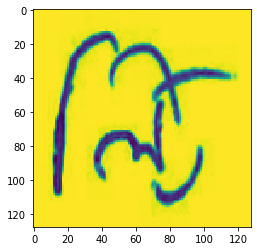

In [0]:
import matplotlib.pyplot as plt


plt.imshow(tot_data.iloc[60].values.reshape(128,128))

In [0]:
'''Load image data and labels'''

tot_file_0 = open(f"/content/drive/My Drive/Untitled folder/bengaliai-cv19/train_0", 'rb')
tot_data_0 = pickle.load(tot_file_0)
tot_file_1 = open(f"/content/drive/My Drive/Untitled folder/bengaliai-cv19/train_1", 'rb')
tot_data_1 = pickle.load(tot_file_1)
tot_file_2 = open(f"/content/drive/My Drive/Untitled folder/bengaliai-cv19/train_2", 'rb')
tot_data_2 = pickle.load(tot_file_2)
tot_file_3 = open(f"/content/drive/My Drive/Untitled folder/bengaliai-cv19/train_3", 'rb')
tot_data_3 = pickle.load(tot_file_3)
tot_data = pd.concat([pd.DataFrame(tot_data_0), pd.DataFrame(tot_data_1), pd.DataFrame(tot_data_2), pd.DataFrame(tot_data_3)],ignore_index=True)
# print(tot_data.shape)
T = tot_data.shape[0]

del tot_file_0
del tot_file_1
del tot_file_2
del tot_file_3

tot_csv = pd.read_csv("/content/drive/My Drive/Untitled folder/bengaliai-cv19/train.csv")
tot_labels = [tot_csv.loc[:T, ['grapheme_root']], 
              tot_csv.loc[:T, ['vowel_diacritic']], 
              tot_csv.loc[:T, ['consonant_diacritic']]]

KeyboardInterrupt: ignored

In [0]:
# Loading the data, run once every load

"""
7 consonant
11 vowel
168 root
"""
from sklearn.model_selection import StratifiedKFold

def returndata(train_size, T, tot_data, tot_labels, tot_csv, SIZE):
    train = tot_data.loc[:train_size-1, ]
    
    train = np.reshape(train.values, (train.shape[0], SIZE, SIZE, 1))

    root_train_labels, vowel_train_labels, consonant_train_labels = (tot_labels[0][:train_size], 
                                       tot_labels[1][:train_size], 
                                       tot_labels[2][:train_size])
    tot_csv = tot_csv[:train_size]

    train, test, root_train_labels, root_test_labels, vowel_train_labels, vowel_test_labels, consonant_train_labels, consonant_test_labels, train_csv, test_csv = train_test_split(train, root_train_labels, vowel_train_labels, consonant_train_labels, tot_csv, test_size=1/6, random_state=666)
    
    test, valid, root_test_labels, root_valid_labels, vowel_test_labels, vowel_valid_labels, consonant_test_labels, consonant_valid_labels, test_csv, valid_csv = train_test_split(test, root_test_labels, vowel_test_labels, consonant_test_labels, test_csv, test_size=0.5, random_state=666)

    return ((train, valid, test), 
            (root_train_labels, root_valid_labels, root_test_labels), 
            (vowel_train_labels, vowel_valid_labels, vowel_test_labels), 
            (consonant_train_labels, consonant_valid_labels, consonant_test_labels),
            (tot_data, tot_labels), (train_csv, valid_csv, test_csv))


In [0]:
TOT_DATA = returndata(50210, T, tot_data, tot_labels, tot_csv, SIZE)

((train_data, valid_data, test_data), 
(root_train_labels, root_valid_labels, root_test_labels), 
(vowel_train_labels, vowel_valid_labels, vowel_test_labels), 
(consonant_train_labels, consonant_valid_labels, consonant_test_labels),
(tot_data, tot_labels), (train_csv, valid_csv, test_csv)) = TOT_DATA

In [0]:
del tot_data

In [0]:
class MulticlassGenerator(keras.preprocessing.image.ImageDataGenerator):

    def flow(self, X, Y,
             batch_size = 256,
             shuffle = True):
        
        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in Y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(X, targets, 
                                         batch_size = batch_size,
                                         shuffle = shuffle):
            target_dict = {}
            
            for i, output in enumerate(ordered_outputs):
                target_dict[output] = flowy[:, i]

            yield flowx, target_dict


## Aug

In [0]:
class GridMask(DualTransform):
    """GridMask augmentation for image classification and object detection.

    Args:
        num_grid (int): number of grid in a row or column.
        fill_value (int, float, lisf of int, list of float): value for dropped pixels.
        rotate ((int, int) or int): range from which a random angle is picked. If rotate is a single int
            an angle is picked from (-rotate, rotate). Default: (-90, 90)
        mode (int):
            0 - cropout a quarter of the square of each grid (left top)
            1 - reserve a quarter of the square of each grid (left top)
            2 - cropout 2 quarter of the square of each grid (left top & right bottom)

    Targets:
        image, mask

    Image types:
        uint8, float32

    Reference:
    |  https://arxiv.org/abs/2001.04086
    |  https://github.com/akuxcw/GridMask
    """

    def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5):
        super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                             int(i * grid_h) : int(i * grid_h + grid_h / 2),
                             int(j * grid_w) : int(j * grid_w + grid_w / 2)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)

    def apply(self, image, mask, rand_h, rand_w, angle, **params):
        h, w = image.shape[:2]
        mask = F.rotate(mask, angle) if self.rotate[1] > 0 else mask
        mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
        image *= mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype)
        return image

    def get_params_dependent_on_targets(self, params):
        img = params['image']
        height, width = img.shape[:2]
        self.init_masks(height, width)

        mid = np.random.randint(len(self.masks))
        mask = self.masks[mid]
        rand_h = np.random.randint(self.rand_h_max[mid])
        rand_w = np.random.randint(self.rand_w_max[mid])
        angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1] > 0 else 0

        return {'mask': mask, 'rand_h': rand_h, 'rand_w': rand_w, 'angle': angle}

    @property
    def targets_as_params(self):
        return ['image']

    def get_transform_init_args_names(self):
        return ('num_grid', 'fill_value', 'rotate', 'mode')

# Model

In [0]:
def create_resnet(inputs, filters, strides):
  activation = keras.activations.get("relu")
  conv = keras.layers.Conv2D(filters, 3, strides=strides, 
                             padding='same', use_bias=False)(inputs)
  conv = keras.layers.Dropout(0.5)(conv)
  norm = keras.layers.BatchNormalization()(conv)
  activ = keras.layers.Activation("relu")(norm)
  conv = keras.layers.Conv2D(filters, 3, strides=1, 
                             padding='same', use_bias=False)(activ)
  norm = keras.layers.BatchNormalization()(conv)

  skip = inputs
  if strides > 1:
    skip = keras.layers.Conv2D(filters, 1, strides=strides,
                        padding='same', use_bias=False)(skip)
    skip = keras.layers.BatchNormalization()(skip)
  return activation(norm + skip)

In [0]:
keras.backend.clear_session()

SIZE=128

inputs = keras.Input(shape = (SIZE, SIZE, 1))

model = keras.layers.Conv2D(64, 3, input_shape=[SIZE, SIZE, 1], activation="relu",
                  padding="same", use_bias=False)(inputs)
model = keras.layers.BatchNormalization()(model)
model = keras.layers.MaxPool2D(3)(model)
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model = create_resnet(model, filters, strides=strides)
    prev_filters = filters
dense = keras.layers.GlobalAveragePooling2D()(model)

dense = keras.layers.Dropout(0.3)(dense)
dense = keras.layers.Dense(1024, activation="elu")(dense)

# model = keras.layers.Flatten()(model)
# dense = keras.layers.Dense(1024, activation="relu")(model)

# dense = keras.layers.Dense(256, activation="relu")(model)

root = keras.layers.Dense(168, name='root', activation="softmax")(dense)
vowel = keras.layers.Dense(11, name='vowel', activation="softmax")(dense)
consonant = keras.layers.Dense(7, name='consonant', activation="softmax")(dense)

model = keras.models.Model(inputs=inputs, outputs=[root, vowel, consonant])

class_weight = {'root':4, 'vowel':3, 'consonant':3}

model.compile(optimizer="adam",
#              keras.optimizers.SGD(lr=0.1, momentum=0.2, nesterov=True), 
              loss={'root': 'sparse_categorical_crossentropy',
                    'vowel': 'sparse_categorical_crossentropy',
                    'consonant': 'sparse_categorical_crossentropy'},
              metrics={'root': 'accuracy',
                       'vowel': 'accuracy',
                       'consonant': 'accuracy'},
              loss_weights=class_weight)

In [0]:
transforms_train = albumentations.Compose([
    GridMask(num_grid=3, rotate=8, p=1),
])

def transforms(image):
  image = cv2.resize(image, (SIZE, SIZE))
  temp = transforms_train(image=image)
  image = temp['image']
  return image[:,:,np.newaxis]

In [0]:
batch_size = 64
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor = 'val_root_loss',
                             patience = 3,
                             factor = 0.5,
                             min_lr = 1e-5,
                             verbose = 1)

earlystop = keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)

checkpoint = keras.callbacks.ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/bengaliai-cv19/saved_models/resnet_2.h5", 
                                 monitor = 'val_root_loss', 
                                 verbose = 0, save_best_only=True, 
                                 mode = 'min',
                                 save_weights_only = True)

In [0]:
del tot_data_0
del tot_data_1
del tot_data_2
del tot_data_3

NameError: ignored

In [0]:
train_datagen = MulticlassGenerator(
    rescale=1./255, 
    rotation_range=8,
    shear_range=2,
    width_shift_range=0.15,
    height_shift_range=0.15,
    preprocessing_function=transforms,
)

datagen = MulticlassGenerator(rescale=1./255)

train_datagen.fit(train_data, augment=True)

train_gen = train_datagen.flow(train_data, {'root':root_train_labels, 'vowel':vowel_train_labels, 'consonant':consonant_train_labels}, 
                         batch_size=batch_size, shuffle=True)
valid_gen = datagen.flow(valid_data, {'root':root_valid_labels,'vowel':vowel_valid_labels,'consonant':consonant_valid_labels}, 
                         batch_size=batch_size, shuffle=False)

gc.collect()

191

### Training loop

In [0]:
!pip install iterative-stratification

In [0]:
# Training Loop
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
train_range = 4
seed = 6666
SIZE=128

histories = []

# model.load_weights("/content/drive/My Drive/Colab Notebooks/bengaliai-cv19/saved_models/resnet_1.h5")

tot_csv = pd.read_csv("/content/drive/My Drive/Untitled folder/bengaliai-cv19/train.csv")

X, y = tot_csv[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values[:,0], tot_csv.values[:,1:]

tot_csv['fold'] = np.nan

#split data
mskf = MultilabelStratifiedKFold(n_splits=5, random_state=666, shuffle=True)
for i, (_, test_index) in enumerate(mskf.split(X, y)):
    tot_csv.iloc[test_index, -1] = i

tot_csv['fold'] = tot_csv['fold'].astype('int')

part = [1]

# for i in range(train_range):

for i in part:
  tot_file = pickle.load(open(f"/content/drive/My Drive/Untitled folder/bengaliai-cv19/Resized/Resized/train_{i}_{SIZE}x{SIZE}", 'rb'))
  T = tot_file.shape[0]
  train_df = tot_csv.iloc[T*i:T*(i+1)]
  train_df.reset_index(drop=True, inplace=True)
  train_file = pd.concat([pd.DataFrame(tot_file), train_df['fold']], axis=1)
  del tot_file
  
  tot_labels = [tot_csv.loc[T*i:T*(i+1)-1, ['grapheme_root', 'fold']], 
              tot_csv.loc[T*i:T*(i+1)-1, ['vowel_diacritic', 'fold']], 
              tot_csv.loc[T*i:T*(i+1)-1, ['consonant_diacritic', 'fold']]]
#   kf = MultilabelStratifiedKFold(n_splits=4, )
#   train_data, test_data, root_train_labels, root_test_labels, vowel_train_labels, vowel_test_labels, consonant_train_labels, consonant_test_labels = train_test_split(train_data, root_train_labels, vowel_train_labels, consonant_train_labels, test_size=0.1, random_state=seed)
#   test_data, valid_data, root_test_labels, root_valid_labels, vowel_test_labels, vowel_valid_labels, consonant_test_labels, consonant_valid_labels = train_test_split(test_data, root_test_labels, vowel_test_labels, consonant_test_labels, test_size=0.5, random_state=seed)
  train_data, valid_data = train_file[train_file['fold']!=0], train_file[train_file['fold']==0]
  train_data.drop('fold', axis=1, inplace=True)
  valid_data.drop('fold', axis=1, inplace=True)
  train_data = np.reshape(train_data.values, (train_data.shape[0], SIZE, SIZE, 1))
  valid_data = np.reshape(valid_data.values, (valid_data.shape[0], SIZE, SIZE, 1))
  del train_file

  root_train_labels, root_valid_labels = tot_labels[0][tot_labels[0]['fold']!=0].drop('fold', axis=1), tot_labels[0][tot_labels[0]['fold']==0].drop('fold', axis=1)
  vowel_train_labels, vowel_valid_labels = tot_labels[1][tot_labels[1]['fold']!=0].drop('fold', axis=1), tot_labels[1][tot_labels[1]['fold']==0].drop('fold', axis=1)
  consonant_train_labels, consonant_valid_labels = tot_labels[2][tot_labels[2]['fold']!=0].drop('fold', axis=1), tot_labels[2][tot_labels[2]['fold']==0].drop('fold', axis=1)

  del train_df
  del tot_labels
  train_datagen = MulticlassGenerator(
      rescale=1./255,
      rotation_range=8,
      shear_range=2,
      width_shift_range=0.15,
      height_shift_range=0.15,
      preprocessing_function=transforms
  )

  datagen = MulticlassGenerator(rescale=1./255)

  train_datagen.fit(train_data)

  train_gen = train_datagen.flow(train_data, {'root':root_train_labels, 'vowel':vowel_train_labels, 'consonant':consonant_train_labels}, 
                         batch_size=batch_size, shuffle=True)
  valid_gen = datagen.flow(valid_data, {'root':root_valid_labels,'vowel':vowel_valid_labels,'consonant':consonant_valid_labels}, 
                         batch_size=batch_size, shuffle=False)

  history = model.fit(train_gen, epochs=60, verbose=1,
          validation_data=valid_gen,
          validation_steps=valid_data.shape[0] // (batch_size),
          steps_per_epoch=train_data.shape[0] // (batch_size), 
          callbacks=[lr_scheduler, earlystop 
                     ,checkpoint
                     ]
          )
  del train_data
  del valid_data

  gc.collect()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


  {'root': '...', 'vowel': '...', 'consonant': '...'}
    to  
  ['...', '...', '...']
  {'root': '...', 'vowel': '...', 'consonant': '...'}
    to  
  ['...', '...', '...']
Train for 628 steps, validate for 155 steps
Epoch 1/60
628/628 [==============================] - 107s 170ms/step - loss: 28.5946 - root_loss: 4.7704 - vowel_loss: 1.9359 - consonant_loss: 1.2351 - root_accuracy: 0.0293 - vowel_accuracy: 0.3112 - consonant_accuracy: 0.6146 - val_loss: 29.4730 - val_root_loss: 4.8328 - val_vowel_loss: 2.0199 - val_consonant_loss: 1.3607 - val_root_accuracy: 0.0242 - val_vowel_accuracy: 0.3310 - val_consonant_accuracy: 0.6107
Epoch 2/60
 83/628 [==>...........................] - ETA: 1:17 - loss: 25.5770 - root_loss: 4.6069 - vowel_loss: 1.3138 - consonant_loss: 1.0692 - root_accuracy: 0.0382 - vowel_accuracy: 0.5286 - consonant_accuracy: 0.6347

### Train

In [0]:
# earlystop = keras.callbacks.EarlyStopping(monitor="val_root_loss", patience=3, restore_best_weights=True)
# model.load_weights("/content/drive/My Drive/Colab Notebooks/bengaliai-cv19/saved_models/densenet_3.h5")
# load = keras.models.load_model("/content/drive/My Drive/Colab Notebooks/bengaliai-cv19/saved_models/densenet_aug_1.h5")

history_res = model.fit(train_gen, epochs=60, verbose=1,
          validation_data=valid_gen,
          validation_steps=valid_data.shape[0] // (batch_size),
          steps_per_epoch=train_data.shape[0] // (batch_size), 
          callbacks=[lr_scheduler, earlystop 
                     ,checkpoint
                     ]
          )

Epoch 1/60
162/162 [==============================] - 109s 672ms/step - loss: 18.3055 - root_loss: 3.3359 - vowel_loss: 0.9526 - consonant_loss: 0.7013 - root_acc: 0.2343 - vowel_acc: 0.6731 - consonant_acc: 0.7666 - val_loss: 16.8698 - val_root_loss: 2.8775 - val_vowel_loss: 1.2444 - val_consonant_loss: 0.5421 - val_root_acc: 0.3203 - val_vowel_acc: 0.5974 - val_consonant_acc: 0.8147
Epoch 2/60
162/162 [==============================] - 64s 394ms/step - loss: 7.1164 - root_loss: 1.2199 - vowel_loss: 0.4226 - consonant_loss: 0.3230 - root_acc: 0.6526 - vowel_acc: 0.8598 - consonant_acc: 0.8946 - val_loss: 7.3771 - val_root_loss: 1.3065 - val_vowel_loss: 0.3993 - val_consonant_loss: 0.3177 - val_root_acc: 0.6377 - val_vowel_acc: 0.8793 - val_consonant_acc: 0.9049
Epoch 3/60
162/162 [==============================] - 62s 385ms/step - loss: 5.1027 - root_loss: 0.8438 - vowel_loss: 0.3237 - consonant_loss: 0.2521 - root_acc: 0.7561 - vowel_acc: 0.8972 - consonant_acc: 0.9181 - val_loss: 4.

In [0]:
import os
model_name = 'densenet_aug_4.h5'
save_dir = os.path.join("/content/drive/My Drive/Colab Notebooks/bengaliai-cv19/", 'saved_models')

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/My Drive/Colab Notebooks/bengaliai-cv19/saved_models/densenet_aug_3.h5 


In [0]:
load = keras.models.load_model("/content/drive/My Drive/Colab Notebooks/bengaliai-cv19/saved_models/densenet_aug_1.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
load.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 3)    30          input_2[0][0]                    
__________________________________________________________________________________________________
densenet121 (Model)             multiple             7037504     conv2d[0][0]                     
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1024)         0           densenet121[1][0]                
______________________________________________________________________________________________

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 3)    30          input_2[0][0]                    
__________________________________________________________________________________________________
densenet121 (Model)             multiple             7037504     conv2d[0][0]                     
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1024)         0           densenet121[1][0]                
______________________________________________________________________________________________

In [0]:
preds_dict = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}
components = ['consonant_diacritic', 'grapheme_root', 'vowel_diacritic']
target=[] 
row_id=[] 

model_1 = keras.models.load_model("/content/drive/My Drive/Colab Notebooks/bengaliai-cv19/saved_models/resnet34_aug_1.h5")
model_2 = keras.models.load_model("/content/drive/My Drive/Colab Notebooks/bengaliai-cv19/saved_models/densenet_aug_1.h5")

for i in range(4):
    testfile_0 = pd.read_parquet('/content/drive/My Drive/Untitled folder/bengaliai-cv19/test_image_data_{}.parquet'.format(i))
    testfile_0.set_index('image_id', inplace=True)
    
    testdata = np.reshape(testfile_0.values, (testfile_0.shape[0], 137, 236, 1))

    new_data = [0] * testdata.shape[0]

    for j in tqdm(range(testdata.shape[0])):

        curpic = testdata[j, :, :, 0]
        # curpic = np.array(curpic,dtype=np.float)
        (x1, x2, y1, y2) = findEdge(curpic, 200)
        
        curpic_2 = np.stack([i[x1:x2] for i in curpic[y1:y2]],axis=0)
        del curpic
        newpic = changeshape(curpic_2, 96, 96) / 255
        del curpic_2
        new_data[j] = newpic
        del newpic

    new_data = np.reshape(np.stack(new_data), (len(new_data), 96, 96, 1))
    
    preds_1 = model_1.predict(new_data)
    preds_2 = model_2.predict(new_data)

    for k, p in enumerate(preds_dict):
        preds_dict[p] = np.argmax((preds_1[k]+preds_2[k])/2, axis=1)

    for l,id in enumerate(testfile_0.index.values):  
        for comp in components:
            id_sample=str(id)+'_'+comp
            row_id.append(id_sample)
            target.append(preds_dict[comp][l])
    del testfile_0

df_sample = pd.DataFrame(
    {
        'row_id': row_id,
        'target':target
    },
    columns = ['row_id','target'] 
)
df_sample.to_csv('submission.csv',index=False)
df_sample